In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv


In [2]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [3]:
df_sample = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')

In [4]:
df_sample[0:5]

,ID,item_cnt_month
0,0,0.50
1,1,0.50
2,2,0.50
3,3,0.50
4,4,0.50


In [5]:
df_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')

In [6]:
df_train[0:5]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,1709.05,1.00
4,15.01.2013,0,25,2555,1099.00,1.00


In [7]:
df_train.shape

(2935849, 6)

In [8]:
df_shop =pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')

In [9]:
df_shop[0:5]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
df_item = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')

In [11]:
df_item[0:5]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [12]:
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

In [13]:
df_test.tail()

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [14]:
df_test[0:5]

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [15]:
df_item_categories =pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')

In [16]:
df_item_categories[0:5]

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [17]:
df_shop.isnull().values.any()

False

merging df_train and df_shop on shop id

In [18]:
df_train = df_train.merge(df_shop,on = ['shop_id'])

In [19]:
df_train[0:5]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name
0,02.01.2013,0,59,22154,999.00,1.00,"Ярославль ТЦ ""Альтаир"""
1,10.01.2013,0,59,22151,399.00,1.00,"Ярославль ТЦ ""Альтаир"""
2,04.01.2013,0,59,5603,699.00,1.00,"Ярославль ТЦ ""Альтаир"""
3,19.01.2013,0,59,5587,199.00,2.00,"Ярославль ТЦ ""Альтаир"""
4,31.01.2013,0,59,5613,5571.00,1.00,"Ярославль ТЦ ""Альтаир"""


In [20]:
df_shop['shop_name'][df_shop['shop_id'] == 59]

59    Ярославль ТЦ "Альтаир"
Name: shop_name, dtype: object

merging df_train and df_item on item id

In [21]:
df_train = df_train.merge(df_item,on = ['item_id'])

In [22]:
df_train[0:5]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id
0,02.01.2013,0,59,22154,999.00,1.00,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37
1,02.01.2013,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37
2,03.01.2013,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37
3,20.01.2013,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37
4,23.01.2013,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37


In [23]:
df_item[df_item['item_id'] == 22154]

,item_name,item_id,item_category_id
22154,ЯВЛЕНИЕ 2012 (BD),22154,37


merging df_train and df_item_categories on item_category_id

In [24]:
df_train = df_train.merge(df_item_categories,on =['item_category_id'])

In [25]:
df_train[0:5]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.00,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,02.01.2013,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,03.01.2013,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,20.01.2013,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,23.01.2013,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [26]:
df_item_categories[df_item_categories['item_category_id'] == 37]

,item_category_name,item_category_id
37,Кино - Blu-Ray,37


In [27]:
df_train.isnull().values.any()

False

In [28]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [29]:
df_train.date = df_train.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [30]:
df_train['date'].describe()

count                 2935849
unique                   1034
top       2013-12-28 00:00:00
freq                     9434
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: date, dtype: object

In [31]:
df_train['date'].min().date()

datetime.date(2013, 1, 1)

In [32]:
df_train['date'].max().date()

datetime.date(2015, 10, 31)

## data cleaning

### item_price

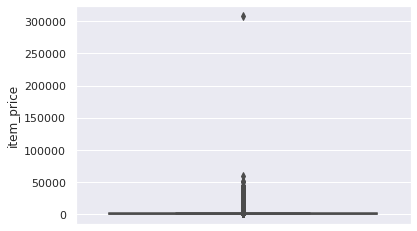

In [33]:
# the skewed box plot shows us the presence of outliers
%matplotlib notebook
%matplotlib inline
sns.boxplot(y="item_price", data =df_train)
plt.show()

In [34]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var = df_train["item_price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1.0
10 percentile value is 149.0
20 percentile value is 199.0
30 percentile value is 299.0
40 percentile value is 349.0
50 percentile value is 399.0
60 percentile value is 599.0
70 percentile value is 799.0
80 percentile value is 1199.0
90 percentile value is 1999.0
100 percentile value is  307980.0


In [35]:
#looking further from the 99th percecntile
for i in range(90,100):
    var = df_train["item_price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 1999.0
91 percentile value is 2090.0
92 percentile value is 2299.0
93 percentile value is 2499.0
94 percentile value is 2599.0
95 percentile value is 2690.0
96 percentile value is 2999.0
97 percentile value is 3190.0
98 percentile value is 3590.0
99 percentile value is 5999.0
100 percentile value is  307980.0


In [36]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =df_train["item_price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 5999.0
99.1 percentile value is 6999.0
99.2 percentile value is 8649.0
99.3 percentile value is 9990.0
99.4 percentile value is 11490.0
99.5 percentile value is 13490.0
99.6 percentile value is 14490.0
99.7 percentile value is 17990.0
99.8 percentile value is 20990.0
99.9 percentile value is 23990.0
100 percentile value is  307980.0


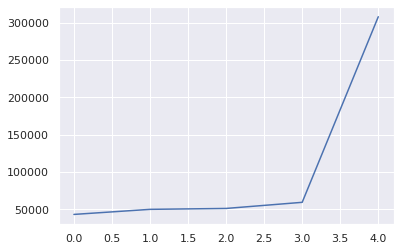

In [37]:
plt.plot(var[-5:])
plt.show()

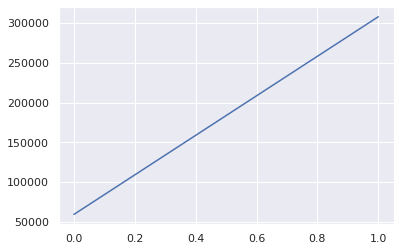

In [38]:
plt.plot(var[-2:])
plt.show()

* so we can set the thresold of 50000

### item_cnt_day

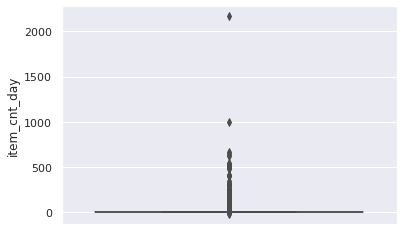

In [39]:
# the skewed box plot shows us the presence of outliers
%matplotlib notebook
%matplotlib inline
sns.boxplot(y="item_cnt_day", data =df_train)
plt.show()

In [40]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var = df_train["item_cnt_day"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -22.0
10 percentile value is 1.0
20 percentile value is 1.0
30 percentile value is 1.0
40 percentile value is 1.0
50 percentile value is 1.0
60 percentile value is 1.0
70 percentile value is 1.0
80 percentile value is 1.0
90 percentile value is 2.0
100 percentile value is  2169.0


In [41]:
#looking further from the 99th percecntile
for i in range(90,100):
    var = df_train["item_cnt_day"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 2.0
91 percentile value is 2.0
92 percentile value is 2.0
93 percentile value is 2.0
94 percentile value is 2.0
95 percentile value is 2.0
96 percentile value is 2.0
97 percentile value is 3.0
98 percentile value is 3.0
99 percentile value is 5.0
100 percentile value is  2169.0


In [42]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =df_train["item_cnt_day"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 5.0
99.1 percentile value is 6.0
99.2 percentile value is 6.0
99.3 percentile value is 7.0
99.4 percentile value is 7.0
99.5 percentile value is 8.0
99.6 percentile value is 10.0
99.7 percentile value is 12.0
99.8 percentile value is 15.0
99.9 percentile value is 22.0
100 percentile value is  2169.0


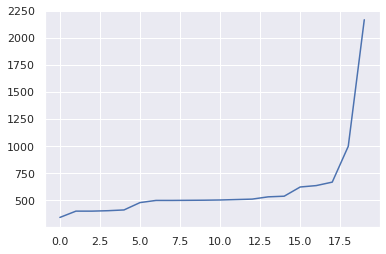

In [43]:
plt.plot(var[-20:])
plt.show()

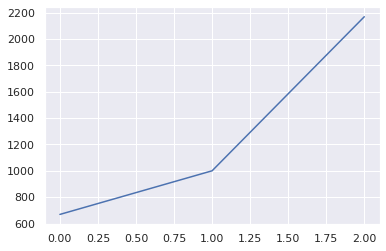

In [44]:
plt.plot(var[-3:])
plt.show()

setting thresold 750

In [45]:
df_train = df_train[df_train['item_price']<50000]

In [46]:
df_train.shape

(2935846, 10)

In [47]:
df_train = df_train[df_train['item_cnt_day']<750]

In [48]:
df_train = df_train[df_train['item_cnt_day']>=0]

In [49]:
df_train.shape

(2928488, 10)

In [50]:
print('Data set size before filter valid:', df_train.shape)
# Only shops that exist in test set.
df_train = df_train[df_train['shop_id'].isin(df_test['shop_id'].unique())]
# Only items that exist in test set.
df_train = df_train[df_train['item_id'].isin(df_test['item_id'].unique())]
print('Data set size after filter valid:', df_train.shape)

Data set size before filter valid: (2928488, 10)
Data set size after filter valid: (1221495, 10)


In [51]:
df_train[0:5]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.00,1.00,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-02,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,2013-01-03,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,2013-01-20,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,2013-01-23,0,25,22154,999.00,1.00,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


conclusion : the shops that are in test data are all present in train data,but train data doesnot consist of all the item that are present in the test data. So we have to fill the missing values.

In [52]:
# Aggregate to monthly level the sales
df_train_groupby= df_train.groupby(["date_block_num","shop_id","item_id"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})

In [53]:
df_train_groupby = df_train_groupby.reset_index()

In [54]:
df_train_groupby[0:5]

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,2,33,499.00,1.00
1,0,2,482,3300.00,1.00
2,0,2,491,600.00,1.00
3,0,2,839,3300.00,1.00
4,0,2,1007,449.00,3.00


In [55]:
df_train_groupby.shape

(599911, 5)

In [56]:
a =  list(df_train_groupby.item_cnt_day)

In [57]:
a

[1.0,
 1.0,
 1.0,
 1.0,
 3.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 6.0,
 4.0,
 3.0,
 3.0,
 1.0,
 3.0,
 1.0,
 1.0,
 17.0,
 2.0,
 2.0,
 6.0,
 1.0,
 1.0,
 1.0,
 2.0,
 5.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 4.0,
 1.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 4.0,
 1.0,
 2.0,
 3.0,
 4.0,
 9.0,
 2.0,
 1.0,
 7.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 4.0,
 4.0,
 2.0,
 3.0,
 1.0,
 4.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 4.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 3.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 3.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 4.0,
 3.0,
 1.0,
 1.0,
 2.0,
 1.0,
 3.0,
 1.0,
 1.0,
 2.0,
 1.0,
 9.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 5.0,
 1.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 4.0,
 1.0,
 1.

In [58]:
df_test[0:5]

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [59]:
df_test.shape

(214200, 3)

In [60]:
final_data = pd.merge(df_test,df_train_groupby,on = ['item_id','shop_id'],how = 'left')

In [61]:
final_data[0:5]

,ID,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,0,5,5037,20.00,2599.00,1.00
1,0,5,5037,22.00,2599.00,1.00
2,0,5,5037,23.00,1999.00,2.00
3,0,5,5037,24.00,1999.00,2.00
4,0,5,5037,28.00,1299.00,1.00


In [62]:
final_data.shape

(702707, 6)

In [63]:
final_data.isnull().values.any()

True

In [64]:
final_data.fillna(0,inplace = True)

In [65]:
final_data.isnull().values.any()

False

In [66]:
final_data.drop(['shop_id','item_id'],inplace = True, axis = 1)


In [67]:
final_data[0:5]

,ID,date_block_num,item_price,item_cnt_day
0,0,20.00,2599.00,1.00
1,0,22.00,2599.00,1.00
2,0,23.00,1999.00,2.00
3,0,24.00,1999.00,2.00
4,0,28.00,1299.00,1.00


In [68]:
#We will create pivot table.
# Rows = each shop+item code
# Columns will be out time sequence
pivot_data = final_data.pivot_table(index='ID',values = 'item_cnt_day' ,columns='date_block_num',fill_value = 0 )

In [69]:
pivot_data.head()

date_block_num,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,...,24.00,25.00,26.00,27.00,28.00,29.00,30.00,31.00,32.00,33.00
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,1,1,1,3,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,2,0,1,3,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
row = 34

In [71]:
pivot_data.values[0:1][0][row-3-1: row -1]

array([1, 3, 1])

In [72]:
sum(a[25:])

1617562.0

In [73]:
a  =(pivot_data[0:1].values)[0]

## now we have predict the sale of the item related to the id for november month

### now using simple moving average

In [159]:
def simple_average(pivot_data,row_no,col_no,window_size):
    predicted_values = []
    for i in range(row_no):
        temp = pivot_data.values[i:i+1][0]
        #print(temp[col_no-window_size-1:col_no-1])
        predict_value = int(sum(temp[col_no-window_size-1:col_no-1])/window_size)
        #print(predict_value)
        predicted_values.append(predict_value)
        
    return predicted_values

In [160]:
def actual_values(pivot_data):
    actual = []
    temp = pivot_data.shape[0]
    for i in range(temp):
        temp = pivot_data.values[i:i+1][0]
        actual.extend([int(temp[-1:])])
    return actual

In [161]:
actual = actual_values(pivot_data)

In [162]:
def rms_error(predicted,actual):
    final =   list(np.array(actual) - np.array(store))
    mse = sum([e**2 for e in final])/len(final)
    return mse

In [163]:
# here we have predicted the october item_cnt using the previous three months
error_values = []
window_lenght = 6
for i in range(2,window_lenght):
    store = simple_average(pivot_data,pivot_data.shape[0],pivot_data.shape[1],i)
    error = rms_error(store,actual)
    error_values.extend([error])

In [164]:
# here we have use window lenght from 2 to 5
print(error_values)

[3.2380112044817926, 3.1179785247432306, 3.1210130718954248, 3.588879551820728]


In [165]:
def predict_nov_simple_average(pivot_data,row_no,col_no,window_size):
    predicted_values = []
    for i in range(row_no):
        temp = pivot_data.values[i:i+1][0]
        #print(temp[col_no-window_size:col_no])
        predict_value = int(sum(temp[col_no-window_size:col_no])/window_size)
        #print(predict_value)
        predicted_values.append(predict_value)
        
    return predicted_values

In [166]:
# we are getting the best result from window_size of 3 so we will use window_size of 3 to predict value for november data
predicted_nov_savg = predict_nov_simple_average(pivot_data,pivot_data.shape[0],pivot_data.shape[1],3)

In [167]:
len(predicted_nov_savg)

214200

In [168]:
predicted_nov_savg

[1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 2,
 3,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 0,
 1,
 1,
 5,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 4,
 5,
 1,
 0,
 1,
 0,
 0,
 1,
 3,
 0,
 0,
 0,
 8,
 5,
 5,
 4,
 7,
 9,
 5,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 8,
 2,
 0,
 1,
 2,
 0,
 0,
 3,
 2,
 1,
 0,
 4,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 3,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 4,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 5,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,

### using weighted average to predict prediction for novrmber month

In [169]:
def weighted_average(pivot_data,row_no,col_no,window_size):
    predicted_values = []
    for i in range(row_no):
        temp = pivot_data.values[i:i+1][0]
        #print(temp[col_no-window_size-1:col_no-1])
        temp = temp[col_no-window_size-1:col_no-1]
        store = 0
        for j in range(1,window_size+1):
            store = store + j*temp[j-1]
        predict_value = int(store/((window_size*(window_size+1))/2))
        #print(predict_value)
        predicted_values.append(predict_value)
        
    return predicted_values

In [170]:
# here we have predicted the october item_cnt using the previous three months
error_values = []
window_lenght = 6
for i in range(2,window_lenght):
    store = weighted_average(pivot_data,pivot_data.shape[0],pivot_data.shape[1],i)
    error = rms_error(store,actual)
    error_values.extend([error])

In [171]:
error_values

[3.3531372549019607, 3.164052287581699, 3.0968814192343603, 3.1585434173669467]

In [172]:
#here the window size of 4 gives the best result so we will use window size of 4 to predict the item_cnt for month november
def predict_nov_weighted_average(pivot_data,row_no,col_no,window_size):
    predicted_values = []
    for i in range(row_no):
        temp = pivot_data.values[i:i+1][0]
        temp = temp[col_no-window_size:col_no]
        #print(temp[col_no-window_size:col_no])
        store =0
        for j in range(1,window_size+1):
            store = store + j*temp[j-1]
        predict_value = int(store/((window_size*(window_size+1))/2))
        #print(predict_value)
        predicted_values.append(predict_value)
        
    return predicted_values

In [173]:
predicted_nov_weighted_average = predict_nov_weighted_average(pivot_data,pivot_data.shape[0],pivot_data.shape[1],4)

In [174]:
len(predicted_nov_weighted_average)

214200

In [175]:
predicted_nov_weighted_average

[1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 2,
 3,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 4,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 3,
 4,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 0,
 0,
 0,
 9,
 4,
 4,
 3,
 7,
 8,
 6,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 7,
 2,
 0,
 1,
 2,
 0,
 0,
 3,
 2,
 1,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 13,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 3,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 3,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,

### using exponential average to predict item_cnt for november month

In [176]:
def exponential_average(pivot_data,row_no,col_no,alpha):
    predicted_values = []
    for i in range(row_no):
        temp = pivot_data.values[i:i+1][0]
        #print(temp[:-1])
        temp = temp[:-1]
        store = 0
        for j in range(len(temp)):
            store = store*(1-alpha) + alpha*temp[j]
        #print(predict_value)
        store = int(store)
        predicted_values.append(store)
        
    return predicted_values

In [177]:
# here we have predicted the october item_cnt using the previous three months
error_values = []
window_lenght = [0.3,0.4,0.5,0.6,0.7]
for i in window_lenght:
    store = exponential_average(pivot_data,pivot_data.shape[0],pivot_data.shape[1],i)
    error = rms_error(store,actual)
    error_values.extend([error])

In [178]:
error_values

[3.186503267973856,
 3.1606816059757237,
 3.1794911297852475,
 3.2454761904761904,
 3.3653874883286647]

In [179]:
def exponential_average_nov(pivot_data,row_no,col_no,alpha):
    predicted_values = []
    for i in range(row_no):
        temp = pivot_data.values[i:i+1][0]
        #print(temp[:-1])
        #temp = temp[:-1]
        store = 0
        for j in range(len(temp)):
            store = store*(1-alpha) + alpha*temp[j]
        #print(predict_value)
        store = int(store)
        predicted_values.append(store)
        
    return predicted_values

In [180]:
predicted_nov_exponential_average = exponential_average_nov(pivot_data,pivot_data.shape[0],pivot_data.shape[1],0.4)

In [181]:
len(predicted_nov_exponential_average)

214200

### now using autoregressive model

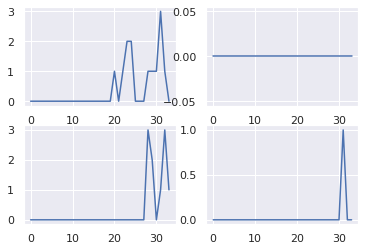

In [74]:
# one thing to consider while autoregressive model is that the value of lag means how many previous values you are going to use
# we can plot autocorelation to find out the value of lag.
# here we are plotting the curve for id 0
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(pivot_data.values[0:1][0])
axs[0,1].plot(pivot_data.values[1:2][0])

axs[1,0].plot(pivot_data.values[2:3][0])
axs[1,1].plot(pivot_data.values[3:4][0])

#plt.plot(series)
plt.show()

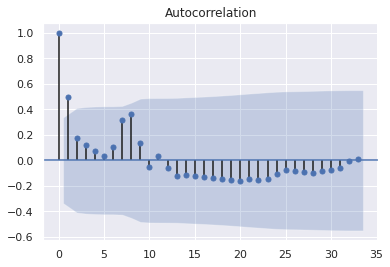

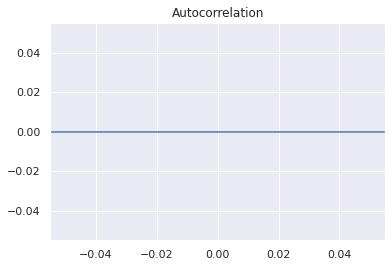

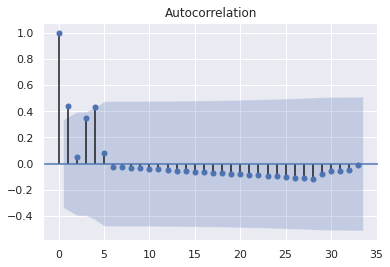

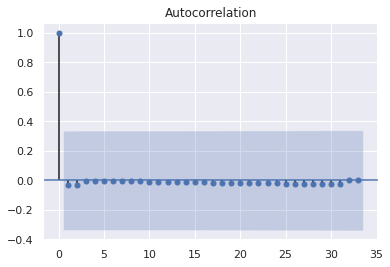

In [76]:
from statsmodels.graphics.tsaplots import plot_acf
#fig, axs = plt.subplots(2, 2)

plot_acf(pivot_data.values[0:1][0],lags = 33)
plot_acf(pivot_data.values[1:2][0],lags = 33)
plot_acf(pivot_data.values[2:3][0],lags = 33)
plot_acf(pivot_data.values[3:4][0],lags = 33)

plt.show()

In [111]:
def auto_regressive(pivot_data,row_no,lag):
    predicted_values = []
    for i in range(row_no):
        data = pivot_data.values[i:i+1][0]
        #print(data[:-1])
        model = AutoReg(data[:-1],lags = lag).fit()
        #print(model.params)
        predict_value = model.predict(start=len(data)-1,end=len(data)-1)
        #print(predict_value)
        predicted_values.append(int(predict_value))  
        
    return predicted_values

In [121]:
'''def auto_regressive_2(pivot_data,row_no,lag):
    predicted_values = []
    for i in range(row_no):
        data = pivot_data.values[i:i+1][0]
        data = data[:-1]
        window = len(data)
        #print(window)
        model = AutoReg(data[:-1],lags = lag).fit()
        parameters = model.params
        yhat = parameters[0]
        for j in range(lag):
            yhat += parameters[j+1] * data[window-j-1]
        #print(model.params)
        #print(yhat)
        #predict_value = model.predict(start=len(data)-1,end=len(data)-1)
        #print(predict_value)
        predicted_values.append(int(yhat))  
        
    return predicted_values'''

In [122]:
'''store = auto_regressive_2(pivot_data,pivot_data.shape[0],4)'''

In [123]:
'''print(rms_error(store,actual))'''

161507.01142857142


In [113]:
# here we have multiple time series for each id 
# we will fit model on series one by one 
# and then check oveall mean squared error
from statsmodels.tsa.ar_model import AutoReg

error_values = []
lag = [2,3,4,5]
for i in lag:
    store = auto_regressive(pivot_data,pivot_data.shape[0],i)
    error = rms_error(store,actual)
    error_values.extend([error])


In [114]:
# the result are not good while using auto regressive model
error_values

[1179.311984126984, 14972.903823529412, 1387182.3654295052, 735744214.5227311]

### now using lstm model for prediction

In [145]:
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(pivot_data.values[:,:-1],axis = 2)
# the last column is our prediction
y_train = pivot_data.values[:,-1:]

In [146]:
X_train.shape

(214200, 33, 1)

In [147]:
y_train.shape

(214200, 1)

In [149]:
# for test we keep all the columns execpt the first one
X_test = np.expand_dims(pivot_data.values[:,1:],axis = 2)

In [150]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.models import load_model, Model

# our defining sales model 
model = Sequential()
model.add(LSTM(units = 64,input_shape = (33,1)))
#sales_model.add(LSTM(units = 64,activation='relu'))
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dropout(0.2))

model.add(Dense(1))


Using TensorFlow backend.


In [151]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 33,537
Trainable params: 33,537
Non-trainable params: 0
____________________________________________________

In [153]:
model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model.fit(X_train,y_train,batch_size = 300,epochs = 10)

Epoch 1/10
714/714 [==============================] - 33s 46ms/step - loss: 5.7450 - mean_squared_error: 5.7450
Epoch 2/10
714/714 [==============================] - 33s 47ms/step - loss: 4.9802 - mean_squared_error: 4.9802
Epoch 3/10
714/714 [==============================] - 33s 46ms/step - loss: 5.0965 - mean_squared_error: 5.0965
Epoch 4/10
714/714 [==============================] - 33s 47ms/step - loss: 5.0216 - mean_squared_error: 5.0216
Epoch 5/10
714/714 [==============================] - 42s 58ms/step - loss: 4.8428 - mean_squared_error: 4.8428
Epoch 6/10
714/714 [==============================] - 33s 46ms/step - loss: 4.7319 - mean_squared_error: 4.7319
Epoch 7/10
714/714 [==============================] - 33s 46ms/step - loss: 4.5214 - mean_squared_error: 4.5214
Epoch 8/10
714/714 [==============================] - 34s 47ms/step - loss: 5.1648 - mean_squared_error: 5.1648
Epoch 9/10
714/714 [==============================] - 33s 46ms/step - loss: 4.3052 - mean_squared_error:

In [154]:
output_november_sales = model.predict(X_test)

In [156]:
output_november_sales[0:10]

array([[0.8638258 ],
       [0.65128314],
       [1.3435899 ],
       [0.6630075 ],
       [0.65128314],
       [1.0241413 ],
       [1.5458927 ],
       [0.5815209 ],
       [1.5343857 ],
       [0.65128314]], dtype=float32)